# Figure 4 Code

This code generates the CNM as well as the significant changes in expression of functional markers in each SC, found in Figure 4. The required input data is the file of single-cells with their type and CN annotations from the CRC dataset.

The "missing jupyter widget" output corresponds to timers from the tqdm package that cannot be displayed after shutting down and restarting the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%pylab inline
import seaborn as sns
import networkx as nx
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import fdrcorrection

Populating the interactive namespace from numpy and matplotlib


In [2]:
#get windows for CRC dataset
cells2 = pd.read_pickle('submissiondata/cells2_salil')

In [3]:
m = cells2.groupby('neighborhood10').apply(lambda x: x['ClusterName'].value_counts(normalize = True)).unstack()

In [4]:
'''
this is the code that finds the minimal combination of CNs
required to make up a threshold percentage of assignments in a window
combinations are stored as a sorted tuple
'''
def get_thresh_simps(x,thresh):
    sorts = np.argsort(-x, axis = 1)
    x_sorted = -np.sort(-x, axis = 1)
    cumsums = np.cumsum(x_sorted,axis = 1)
    thresh_simps = pd.Series([tuple(sorted(sorts[i,:(1+j)])) for i,j in enumerate(np.argmax(cumsums>thresh,axis = 1))])
    return thresh_simps

In [55]:
w = pd.read_csv('submissiondata/windows_and_SCs_spotsover750cells.csv')
w['neighborhood10'] = w['neighborhood10'].astype('category')
l = ['0','1','2','3','4','5','6','7','8','9']
k = 50
x = w.loc[:,l].values/k
simps = get_thresh_simps(x,.90)
w['combination'] = [tuple(l[a] for a in s) for s in simps]
bulk_simp_freqs = (w.groupby('combination').size()/len(w)).to_dict()

In [6]:
spot_SCs = w.groupby(['patients','combination']).size().reset_index()
sc_pat_counts = spot_SCs.loc[spot_SCs[0]>25].loc[:,['patients','combination']].groupby('combination').size()
selected_simps = sc_pat_counts[sc_pat_counts>=10].index.values


In [11]:
checkpoint_cells = ['CD11c+Ki67+','CD11c+PD-1+','CD11c+VISTA+',
'CD68+CD163+PD-1+','CD68+CD163+Ki67+','CD68+CD163+VISTA+',
'CD38+Ki67+',
'CD20+PD-1+','CD20+Ki67+',
'CD8+PD-1+', 'CD8+Ki67+',
'Treg-PD-1+','Treg-Ki67+',
'CD4+PD-1+', 'CD4+Ki67+']

parents = ['CD4+', 'CD8+', 'CD20+', 'CD38+', 'CD68+CD163+', 'CD11c+', 'CD25+FOXP3+']


parent_checkpointlist = {'CD11c+':['CD11c+Ki67+','CD11c+PD-1+','CD11c+VISTA+'],
'CD68+CD163+': ['CD68+CD163+PD-1+','CD68+CD163+Ki67+','CD68+CD163+VISTA+'],
'CD38+': ['CD38+Ki67+'],
'CD20+':['CD20+PD-1+','CD20+Ki67+'],
'CD8+':['CD8+PD-1+', 'CD8+Ki67+'],
'CD25+FOXP3+':['Treg-PD-1+','Treg-Ki67+'],
'CD4+':['CD4+PD-1+', 'CD4+Ki67+']}

all_spots = w['spots'].unique()

## percent of positive in SC relative to random samples per spot

In [12]:
parent_spot_cells = {}
for parent in parents:
    parent_spot_cells[parent] = w[w[parent]==1].groupby('spots').groups

### Generate 30000 random samples for each spot

In [13]:
parent_spot_perms = {}
num_perm = 30000

np.random.seed(4)
for parent in parents:
    parent_spot_perms[parent] = {}
    for spot in tqdm(all_spots):
        spot_parent_idxs = parent_spot_cells[parent][spot].values
        parent_spot_perms[parent][spot] = np.zeros((num_perm, len(spot_parent_idxs)),dtype = np.int64)
        for i in range(num_perm):
            shuf = spot_parent_idxs.copy()
            np.random.shuffle(shuf)
            parent_spot_perms[parent][spot][i] = shuf

### Compute deviation of percentage of parent from perm distribution

In [20]:
ens = {}
pvals = {}
for sc in tqdm(selected_simps):
    ens[sc] = {}
    pvals[sc] = {}
    sc_cells = w[w['combination']==sc]
    for parent,checkpointlist in parent_checkpointlist.items():
        sc_parent_cells = sc_cells[sc_cells[parent]==1]
        sc_spot_parent_counts =sc_parent_cells.groupby('spots').size()
        ct_df = w.loc[:,checkpointlist]
        samp_array = np.zeros((len(sc_spot_parent_counts), num_perm, len(ct_df.columns)))
        for idx,spot in enumerate(sc_spot_parent_counts.index.values):
            if sc_spot_parent_counts.loc[spot] == parent_spot_perms[parent][spot].shape[1]:
                start ==0
            else:
                start = np.random.randint(parent_spot_perms[parent][spot].shape[1]-sc_spot_parent_counts.loc[spot])
                
            cells_to_get = parent_spot_perms[parent][spot][:,start:(start+sc_spot_parent_counts.loc[spot])]
            samp_array[idx] = ct_df.loc[cells_to_get.flatten()].values.reshape((cells_to_get.shape[0], cells_to_get.shape[1],len(ct_df.columns))).sum(axis = 1)
        samp_mean = samp_array.sum(axis = 0)/len(sc_parent_cells)
        obs_mean = ct_df.loc[sc_parent_cells.index.values].mean(axis = 0)
        p_greater = 1 - (samp_mean < obs_mean[None,:]).mean(axis = 0)
        p_less = 1 - (samp_mean > obs_mean[None,:]).mean(axis = 0)
        ens[sc,parent] = np.log2(((1e-4+obs_mean[None,:])/(1e-4+samp_mean)))
        pvals[sc,parent] = np.maximum(1/num_perm, np.minimum(p_greater,p_less))
        
        

### Compute FDR by combining p-values

In [21]:
to_correct = []
names = []
for sc in selected_simps:
    sc_cells = w[w['combination']==sc]
    for parent,checkpointlist in parent_checkpointlist.items():
        if parent =='CD38+':
            continue
        sc_parent_cells = sc_cells[sc_cells[parent]==1]
        sc_pat_parent_counts =sc_parent_cells.groupby('patients').size()
        if len(sc_pat_parent_counts)>=5:
            en = np.median(ens[sc,parent],axis = 0)
            for j,chk in enumerate(checkpointlist):
                if en[j]>0:
                    to_correct.append(pvals[sc,parent][j])
                    names.append((sc,chk,'pos'))
                if en[j]<0:
                    to_correct.append(pvals[sc,parent][j])
                    names.append((sc,chk,'neg'))


### Identify significant ones and rename for the map

In [22]:
chk_par  = {'CD11c+Ki67+': 'CD11c+',
 'CD11c+PD-1+': 'CD11c+',
 'CD11c+VISTA+': 'CD11c+',
 'CD68+CD163+PD-1+': 'CD68+CD163+',
 'CD68+CD163+Ki67+': 'CD68+CD163+',
 'CD68+CD163+VISTA+': 'CD68+CD163+',
 'CD38+Ki67+': 'CD38+',
 'CD20+PD-1+': 'CD20+',
 'CD20+Ki67+': 'CD20+',
 'CD8+PD-1+': 'CD8+',
 'CD8+Ki67+': 'CD8+',
 'Treg-PD-1+': 'CD25+FOXP3+',
 'Treg-Ki67+': 'CD25+FOXP3+',
 'CD4+PD-1+': 'CD4+',
 'CD4+Ki67+': 'CD4+'}

In [23]:
parent_names = {
 'CD4+':'CD4$^+$ T: ', 
'CD8+': 'CD8$^+$ T: ',
    'CD20+': 'B cell: ',
    'CD38+': 'plasma/activated cell: ',
    'CD68+CD163+': 'MΦ: ',
    'CD11c+': 'DC: ',
    'CD25+FOXP3+': 'Treg: '   
}

In [24]:
sc_to_sig_chks = {}
for sc, chk, ud in [names[j] for j in np.where(fdrcorrection(to_correct)[1]<0.05)[0]]:
    sc_to_sig_chks.setdefault(sc,{}).setdefault(parent_names[chk_par[chk]], {}).setdefault(ud, set()).add(chk.split(chk_par[chk])[-1][:-1])
    

In [25]:
cn_name_map = {'0':1}

###  Draw graph

In [27]:
'''
this builds the graph for the CN combination map
'''
g = nx.DiGraph()
for e0 in selected_simps:
    for e1 in selected_simps:
        if (set(list(e0))<set(list(e1))) and (len(e1) == len(e0)+1):
            g.add_edge(e0,e1)

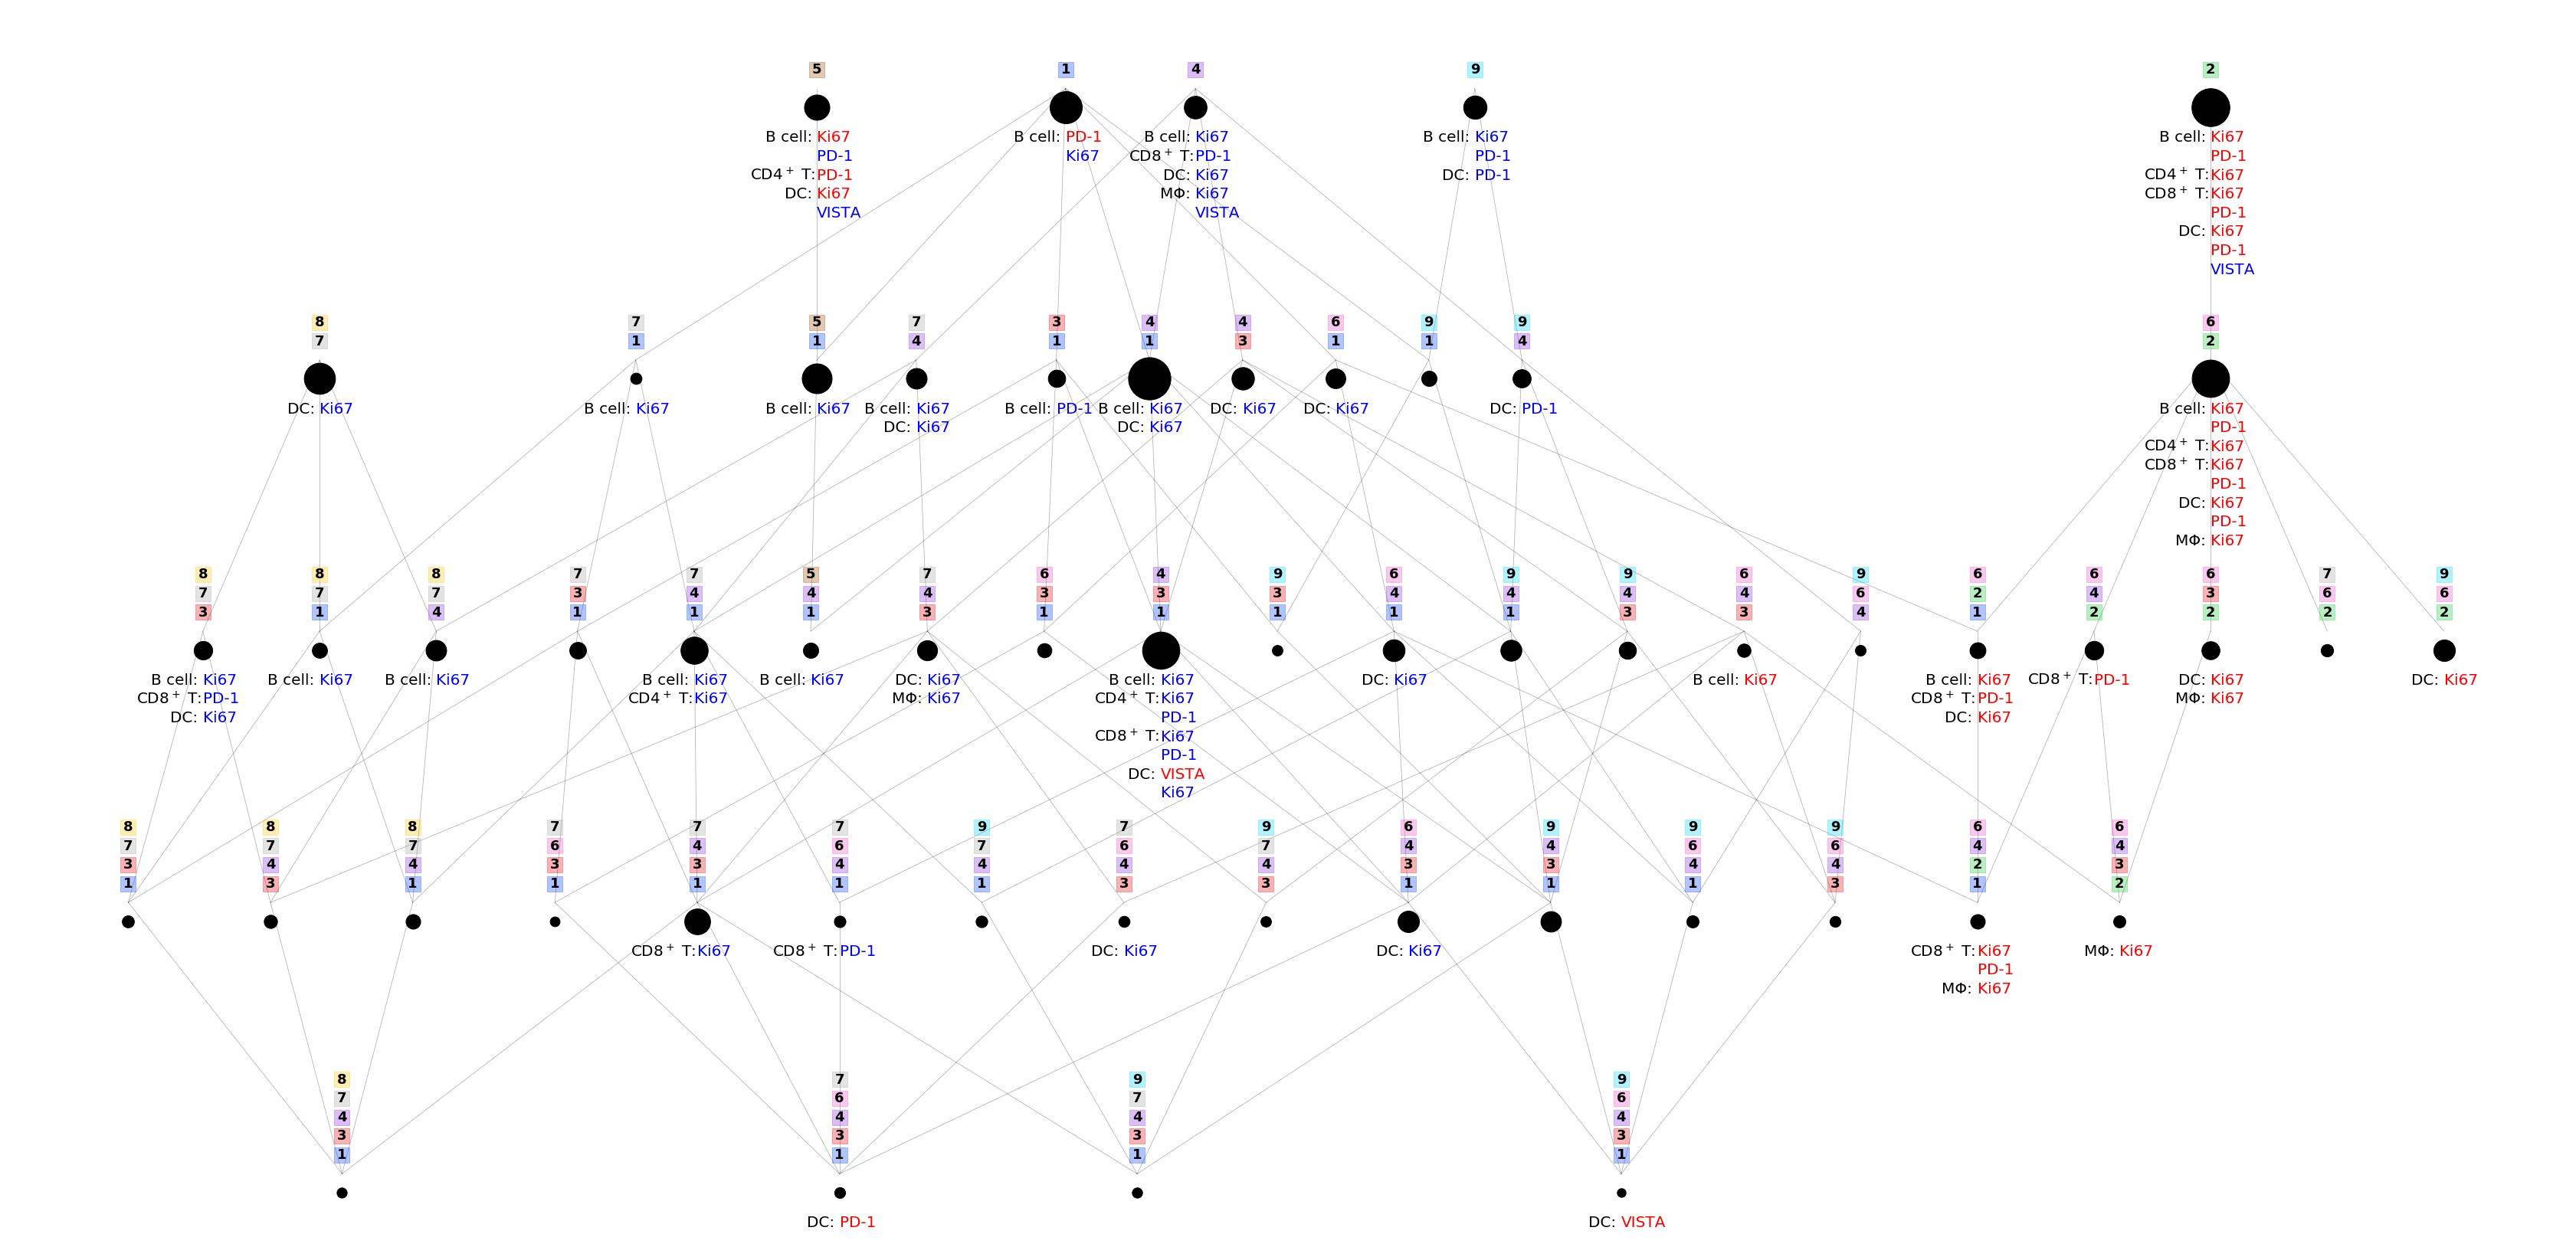

In [60]:

draw = g
pos = nx.drawing.nx_pydot.graphviz_layout(draw, prog='dot')
plt.figure(figsize = (60,30))
pal = sns.color_palette('bright',10)
for n in draw.nodes():
    colpal = sns.color_palette('bwr',100)
    vmin = -2
    vmax = 2
    
    col = 'black'
    if len(draw.in_edges(n))<len(n):
        col = 'black'
  
    plt.scatter(pos[n][0],pos[n][1]-5, s = 5*bulk_simp_freqs[n]*10000, c = ['black'], vmax = 20, zorder = -1)
    
    
    delta = 5

    plt.scatter([pos[n][0]]*len(n),[pos[n][1]+delta*(i+1) for i in range(len(n))],c = [pal[int(i)] for i in n] ,marker = 's', alpha = .3,zorder = 5,s = 400)
    for i in range(len(n)):
        plt.text(pos[n][0],pos[n][1]+delta*(i+1),cn_name_map.setdefault(n[i],n[i]), ha = 'center', va = 'center',fontsize = 18,zorder = 20,weight = 'bold')
    
    

    rrr = 1
    for ct in sorted(sc_to_sig_chks.setdefault(n, {}).keys()):
        plt.text(pos[n][0],-8-5*rrr+ pos[n][1],ct,fontsize = 20, ha = 'right', va = 'center', c = 'black')
        for mark in sorted(sc_to_sig_chks[n][ct].setdefault('pos', set())):
            plt.text(pos[n][0],-8-5*rrr+ pos[n][1],mark,fontsize = 20, ha = 'left', va = 'center', c = 'red')
            rrr +=1 
        for mark in sorted(sc_to_sig_chks[n][ct].setdefault('neg', set())):
            plt.text(pos[n][0],-8-5*rrr+ pos[n][1],mark,fontsize = 20, ha = 'left', va = 'center', c = 'blue')
            rrr +=1 
            

        
j = 0
for e0,e1 in draw.edges():
    weight = .8
    alpha = .3
    
    color = 'black'


    plt.plot([pos[e0][0], pos[e1][0]],[pos[e0][1], pos[e1][1]], color = color, linewidth = weight,alpha = alpha,zorder = -10)

plt.axis('off')

plt.show()
